In [2]:
import json
from reach import Reach

In [4]:
with open("../data/topics.json", "r") as f:
    d = json.load(f)

In [ ]:
from gensim.utils import simple_preprocess

In [ ]:
desc = []
query_desc = []
topics = []
peoples = []
for key, values in d.items():
    for topic, v in values.items():
        if topic not in ['Chambre', 'Emplacement', 'Ambiance', 'Rapport qualité-prix', 'Personnel']: continue
        desc.append(v)
        query_desc.append("query: "+" ".join(simple_preprocess(v, deacc=True)))
        topics.append(topic)
        peoples.append(key)

In [7]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('intfloat/multilingual-e5-base', device='cpu')
sbert_embeddings = model.encode(query_desc, normalize_embeddings=True, show_progress_bar=True)

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
from bertopic import BERTopic
from sklearn.cluster import KMeans
from umap import UMAP
import matplotlib.pyplot as plt

/tmp/ipykernel_5084/3875426022.py:118: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/tmp/ipykernel_5084/3875426022.py:118: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



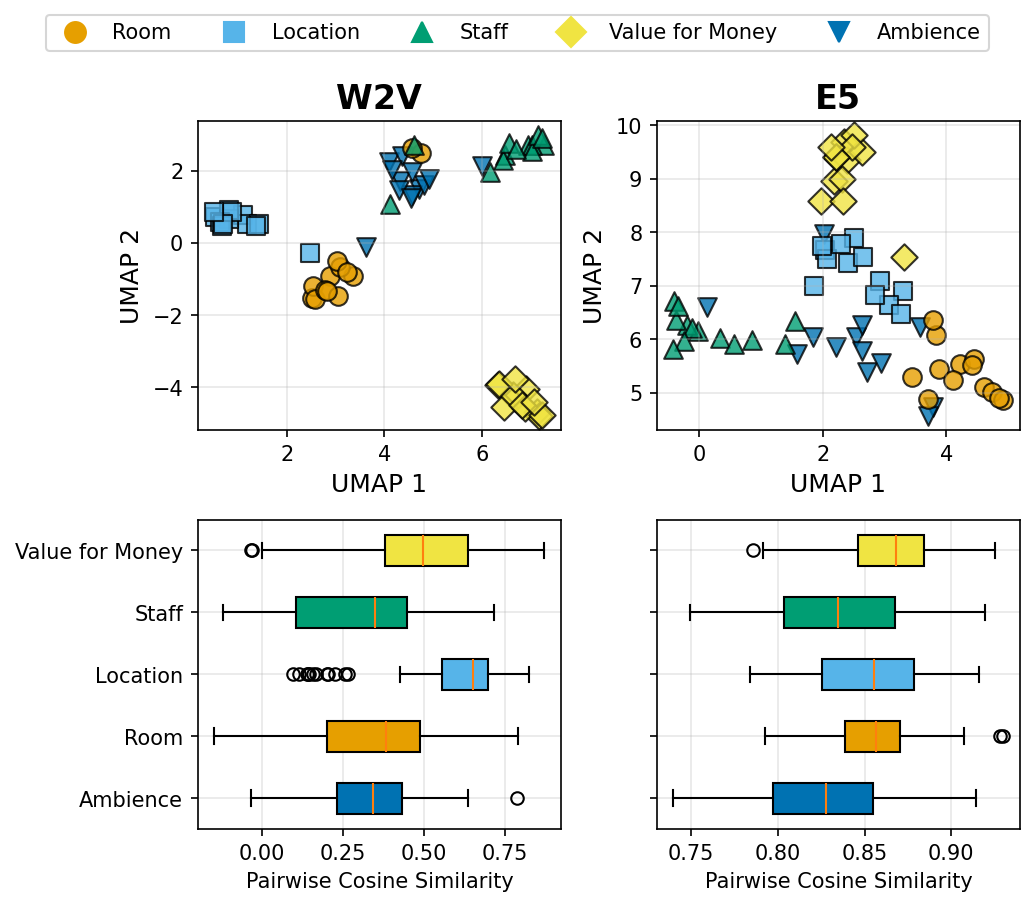

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.metrics import silhouette_samples
from scipy.spatial.distance import pdist

# ---------------- Translation Dictionary ----------------
TRANSLATION_TOPICS = {
    "Rapport qualité-prix": "Value for Money",
    "Ambiance": "Ambience",
    "Chambre": "Room",
    "Emplacement": "Location",
    "Personnel": "Staff"
}

# ---------------- Example placeholders ----------------
# Replace these with your actual embeddings and topic labels
# sbert_embeddings = np.array([...])
# cbow_embeddings = np.array([...])
# topics = ['chambre', 'emplacement', 'personnel', 'rapport qualité-prix', 'ambiance', ...]

# ---------------- Color & Marker Dictionaries ----------------
color_dict_cb = {
    'chambre': '#E69F00',               
    'emplacement': '#56B4E9',           
    'personnel': '#009E73',             
    'rapport qualité-prix': '#F0E442',  
    'ambiance': '#0072B2',              
}

marker_dict = {
    'chambre': 'o',               
    'emplacement': 's',           
    'personnel': '^',             
    'rapport qualité-prix': 'D',  
    'ambiance': 'v',              
}

# ---------------- Helper Function ----------------
def translate_topic(topic):
    return TRANSLATION_TOPICS.get(topic.lower().capitalize(), topic)

# ---------------- UMAP Reduction Function ----------------
def reduce_umap(embeddings):
    reducer = umap.UMAP(
        n_components=2,
        metric='cosine',
        random_state=42,
        n_neighbors=10,
        min_dist=0.0
    )
    return reducer.fit_transform(embeddings)

embedding_2d_sbert = reduce_umap(sbert_embeddings)

# ---------------- Silhouette Computation ----------------
silhouette_sbert = silhouette_samples(embedding_2d_sbert, labels=topics, metric='euclidean')
silhouette_cbow = silhouette_samples(embedding_2d_cbow, labels=topics, metric='euclidean')

def silhouette_boxplot_data(silhouette_scores, labels):
    topic_sil = []
    topic_names = []
    for topic in np.unique(labels):
        idxs = [i for i, t in enumerate(labels) if t == topic]
        topic_sil.append(silhouette_scores[idxs])
        topic_names.append(topic)
    return topic_sil, topic_names

sbert_box_data, sbert_topics = silhouette_boxplot_data(silhouette_sbert, topics)
cbow_box_data, cbow_topics = silhouette_boxplot_data(silhouette_cbow, topics)

# ---------------- Cosine Similarity ----------------
def cosine_boxplot_data(embeddings, labels):
    topic_cosims, topic_names = [], []
    for topic in np.unique(labels):
        idxs = [i for i, t in enumerate(labels) if t == topic]
        if len(idxs) > 1:
            subset = embeddings[idxs]
            dists = pdist(subset, metric='cosine')
            sims = 1 - dists
            topic_cosims.append(sims)
            topic_names.append(topic)
    return topic_cosims, topic_names

sbert_cos_data, sbert_topics = cosine_boxplot_data(sbert_embeddings, topics)

# ---------------- Combined Plot ----------------
fig, axes = plt.subplots(2, 2, figsize=(7, 6), dpi=150)

# --------- Top Row: UMAP Scatter Plots ---------
for ax, embedding_2d, title in zip(axes[0], 
                                   [embedding_2d_sbert],
                                   ['E5']):
    for topic in np.unique(topics):
        idx = [i for i, t in enumerate(topics) if t == topic]
        ax.scatter(
            embedding_2d[idx, 0], embedding_2d[idx, 1],
            c=color_dict_cb.get(topic.lower(), 'lightgray'),
            marker=marker_dict.get(topic.lower(), 'o'),
            s=80,
            alpha=0.8,
            edgecolor='k',
            label=translate_topic(topic)
        )
    ax.set_title(title, fontsize=16, weight='bold')
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.grid(alpha=0.3)

i = 0
# --------- Bottom Row: Cosine Similarity Boxplots (Horizontal) ---------
for ax, box_data, topic_names, title in zip(axes[1],
                                            [cbow_topics, sbert_topics],
                                            ['SBERT Cosine Similarity', 'CBOW Cosine Similarity']):
    box = ax.boxplot(box_data, labels=[translate_topic(t) for t in topic_names], patch_artist=True, vert=False)
    for patch, topic in zip(box['boxes'], topic_names):
        patch.set_facecolor(color_dict_cb.get(topic.lower(), 'lightgray'))
    ax.set_xlabel("Pairwise Cosine Similarity")
    ax.grid(alpha=0.3)
    if i == 0:
        ax.set_yticklabels([translate_topic(t) for t in topic_names], rotation=0, ha='right')
        i += 1
    else:
        ax.set_yticklabels([" " for t in topic_names], rotation=0, ha='right')
    #ax.set_title(title, fontsize=14, weight='bold')

# --------- Combined Legend for Scatter (Horizontal, Top) ---------
handles = [plt.Line2D([], [], marker=marker_dict[t], linestyle='', color=color_dict_cb[t],
                      markersize=10, label=translate_topic(t)) for t in color_dict_cb]
fig.legend(
    handles=handles,
    loc='upper center',
    ncol=len(handles),
    bbox_to_anchor=(0.5, 1),
    borderaxespad=0.,
    frameon=True
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('embeddings_visu.png')
plt.show()


/tmp/ipykernel_5084/3691262982.py:24: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/tmp/ipykernel_5084/3691262982.py:52: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



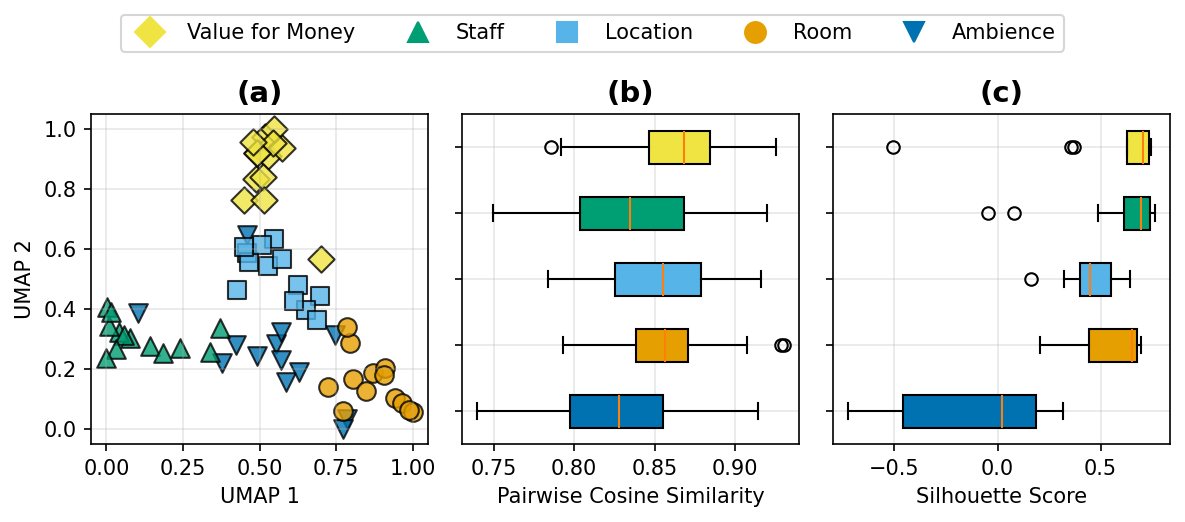

In [13]:
# ---------------- Single-Row Figure with 3 Plots ----------------
fig, axes = plt.subplots(1, 3, figsize=(8, 3.5), dpi=150)

# --------- 1) UMAP SBERT ---------
ax = axes[0]
for topic in np.unique(topics):
    idx = [i for i, t in enumerate(topics) if t == topic]
    ax.scatter(
        embedding_2d_sbert[idx, 0], embedding_2d_sbert[idx, 1],
        c=color_dict_cb.get(topic.lower(), 'lightgray'),
        marker=marker_dict.get(topic.lower(), 'o'),
        s=80,
        alpha=0.8,
        edgecolor='k',
        label=translate_topic(topic)
    )
ax.set_title("(a)", fontsize=14, weight='bold')
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.grid(alpha=0.3)

# --------- 2) Cosine Similarity ---------
ax = axes[1]
box = ax.boxplot(
    sbert_cos_data,
    labels=[translate_topic(t) for t in sbert_topics],
    patch_artist=True,
    vert=False
)
for patch, topic in zip(box['boxes'], sbert_topics):
    patch.set_facecolor(color_dict_cb.get(topic.lower(), 'lightgray'))

ax.set_title("(b)", fontsize=14, weight='bold')
ax.set_xlabel("Pairwise Cosine Similarity")
ax.set_yticklabels([])   # remove y-tick labels
ax.grid(alpha=0.3)

# --------- 3) Silhouette Scores ---------
silhouette_sbert = silhouette_samples(embedding_2d_sbert, labels=topics, metric='euclidean')

def silhouette_boxplot_data(silhouette_scores, labels):
    topic_sil, topic_names = [], []
    for topic in np.unique(labels):
        idxs = [i for i, t in enumerate(labels) if t == topic]
        topic_sil.append(silhouette_scores[idxs])
        topic_names.append(topic)
    return topic_sil, topic_names

sbert_sil_data, sbert_sil_topics = silhouette_boxplot_data(silhouette_sbert, topics)

ax = axes[2]
box = ax.boxplot(
    sbert_sil_data,
    labels=[translate_topic(t) for t in sbert_sil_topics],
    patch_artist=True,
    vert=False
)
for patch, topic in zip(box['boxes'], sbert_sil_topics):
    patch.set_facecolor(color_dict_cb.get(topic.lower(), 'lightgray'))

ax.set_title("(c)", fontsize=14, weight='bold')
ax.set_xlabel("Silhouette Score")
ax.set_yticklabels([])  # remove y-tick labels
ax.grid(alpha=0.3)

# --------- Combined Legend ---------
handles = [
    plt.Line2D([], [], marker=marker_dict[t], linestyle='', color=color_dict_cb[t],
               markersize=10, label=translate_topic(t))
    for t in color_dict_cb
]

legend_order = ['rapport qualité-prix', 'personnel', 'emplacement', 'chambre', 'ambiance']

# Reorder handles
ordered_handles = [h for t in legend_order 
                   for h in handles 
                   if h.get_label() == translate_topic(t)]

# Add figure-level legend
fig.legend(
    handles=ordered_handles,
    labels=[h.get_label() for h in ordered_handles],
    loc='upper center',
    ncol=len(ordered_handles),
    frameon=True,
    bbox_to_anchor=(0.5, 1)
)

plt.tight_layout(rect=[0, 0, 1, 0.9])  # leave space at the top
plt.savefig("embeddings_visu_3plots.png")
plt.show()


In [18]:
from scipy.spatial.distance import cdist

closest_points = {}

for topic in np.unique(topics):
    # indices of points for this topic
    idxs = [i for i, t in enumerate(topics) if t == topic]
    topic_points = embedding_2d_sbert[idxs]
    
    # compute centroid
    centroid = topic_points.mean(axis=0)
    
    # compute distances from centroid
    distances = cdist([centroid], topic_points)  # shape (1, n_points)
    closest_idx_within_topic = idxs[distances.argmin()]  # original index in embedding_2d_sbert
    
    closest_points[topic] = {
        "centroid": centroid,
        "closest_index": closest_idx_within_topic
    }

# Print the results
for topic, data in closest_points.items():
    print(f"{topic}")
    print(f"{query_desc[data['closest_index']]}\n")



Ambiance
query: il agit une atmosphere materielle ou morale qui environne une personne une ambiance peut donc etre defini par la somme des differents elements que constitue cette atmosphere comme par exemple des couleurs chaudes et des personnes souriantes et aimantes pour une ambiance chaleureuse synonyme de bien etre ou bien des couleurs froides et tristes ainsi que des personnes peu accueillantes pourrait etre synonyme ambiance froide synonyme de mal etre

Chambre
query: une chambre est un lieu de repos disposant un lit simple pour une personne ou deux places pour deux personnes le lit dispose un sommier et un matelas qui doit etre confortable et agreable une ambiance cosy est de rigueur afin apprecier le repos offert par la piece la chambre peut etre agrementee equipements supplementaires afin en augmenter le confort table de nuit television etc

Emplacement
query: est la localisation geographique un lieu

Personnel
query: comprends toutes les personnes travaillant pour hotel

Rapp